## Gamma-ray energy deposition

In [1]:
import numpy as np
import astropy.units as u

from tardis.energy_input.base import GXPacket, main_gamma_ray_loop
from tardis.energy_input.calculate_opacity import compton_opacity_calculation, photoabsorption_opacity_calculation, pair_creation_opacity_calculation, kappa_calculation
from tardis.energy_input.gamma_ray_grid import distance_trace, move_gamma_ray
from tardis.energy_input.gamma_ray_interactions import scatter_type
import tardis.energy_input.util as util
import tardis.constants as const
import tardis.energy_input.calculate_opacity as calculate_opacity

/home/afullard/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


### Main loop

Generates a simple 1D ejecta and a list of gamma-ray objects.

Runs packets of gamma-rays through the ejecta. Handles interactions by calling the appropriate function. 

Appends deposited energy and output energy to 2 different lists. Currently no binning.

In [4]:
import matplotlib.pyplot as plt
from tardis.model import Radial1DModel
from tardis.io.config_reader import Configuration

num_packets = 10000
num_packets = int(num_packets)

np.random.seed(1)

config = Configuration.from_yaml("../../tardis/io/tests/data/tardis_configv1_density_exponential_nebular.yml")
config.model.structure.velocity.start = 1 * u.km / u.s
#config.model.structure.velocity.stop = 2e4 * u.km / u.s
#config.supernova.time_explosion = 240 * u.day
config.model.structure.density.rho_0 = 5e2 * u.g / (u.cm ** 3)
#config.model.structure.density.v_0 = 5e3 * u.km / u.s
#config.model.structure.density.time_0 = 240 * u.day

model = Radial1DModel.from_config(config)

(
    ejecta_energy_df,
    ejecta_plot_energy_df,
    escape_energy
) = main_gamma_ray_loop(
    num_packets,
    model,
)

ejecta_energy = ejecta_plot_energy_df["energy_input"]
ejecta_energy_r = ejecta_plot_energy_df["energy_input_r"]
energy_input_time = ejecta_plot_energy_df["energy_input_time"]
energy_input_type = ejecta_plot_energy_df["energy_input_type"]



Ni56 is already in the database (force_update to overwrite)
Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed
Ni57 is already in the database (force_update to overwrite)
Data Type Author not known and not parsed
Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed


  0%|          | 0/10002 [00:00<?, ?it/s]

[]

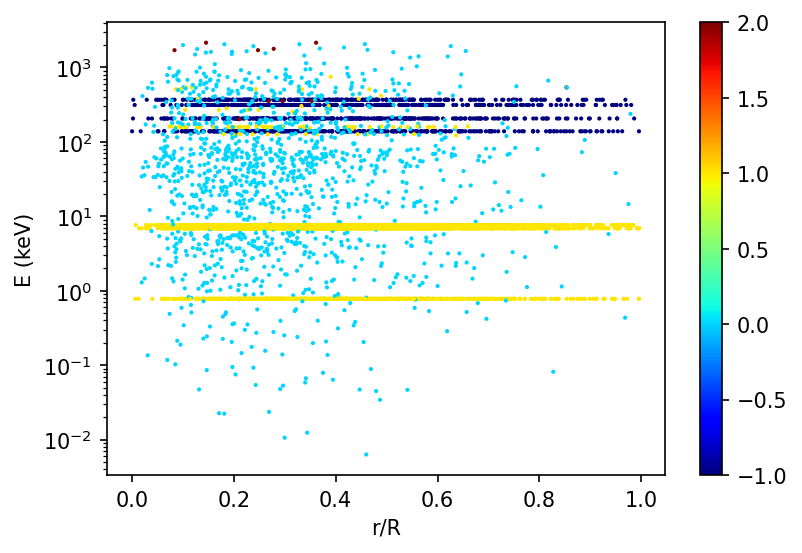

In [5]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)

velocity = (np.array(ejecta_energy_r)/(config.supernova.time_explosion * u.day.to(u.s))) * u.cm.to(u.km)
# ax.vlines(radii/np.max(model.r_outer.value), 0, 3500, linestyle="--", color="gray", alpha=0.2)
scatter = ax.scatter(np.array(ejecta_energy_r)/np.max(model.v_outer.value), np.array(ejecta_energy), c=energy_input_type, s=1, cmap="jet")
cbar = plt.colorbar(scatter, ax=ax)
ax.set_xlabel("r/R")
ax.set_ylabel("E (keV)")
ax.semilogy()


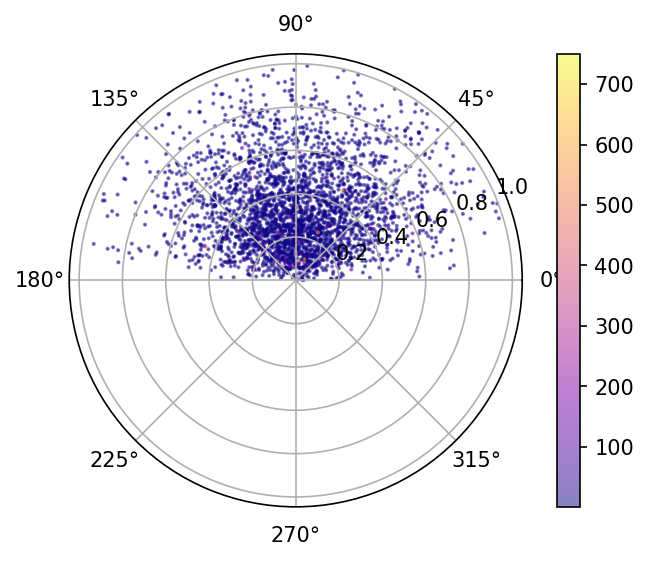

In [6]:
ejecta_energy_theta = ejecta_plot_energy_df["energy_input_theta"]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150, facecolor='w')
plot = ax.scatter(np.array(ejecta_energy_theta)[np.array(energy_input_type) == 1], np.array(ejecta_energy_r)[np.array(energy_input_type) == 1]/np.max(model.v_outer[:].value), c=np.array(ejecta_energy)[np.array(energy_input_type) == 1], s=1, alpha=0.5, cmap="plasma")
cbar = plt.colorbar(plot, ax=ax)

(0.0, 1.0)

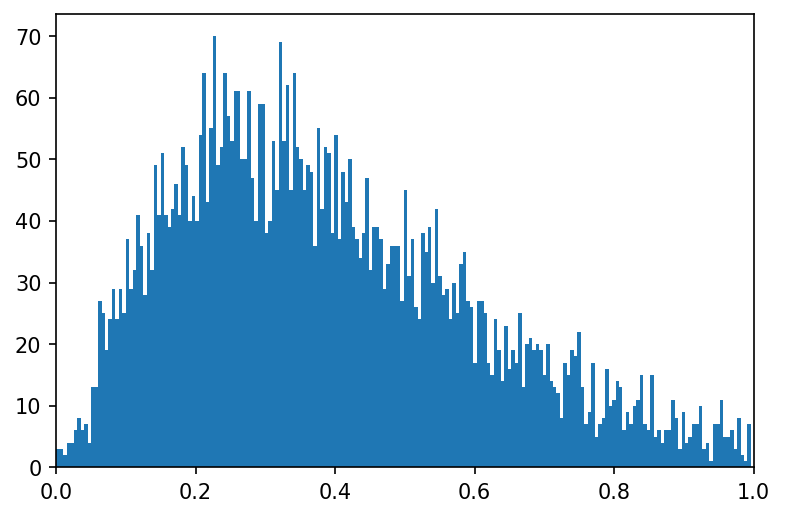

In [7]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(ejecta_energy_r)/np.max(model.v_outer[:].value), bins=200)
#ax.semilogy()
ax.set_xlim(0, 1)

# Total Mass

In [8]:
np.sum((model.density * model.volume)).to(u.M_sun)

<Quantity 1.31957869 solMass>

# Density Profile

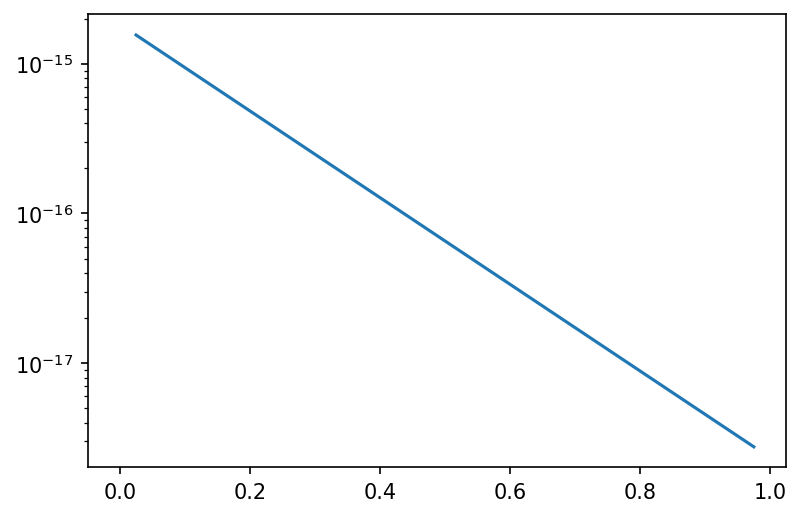

In [9]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.r_middle/np.max(model.r_outer), model.density)
plt.plot(0,0)

In [10]:
sum(escape_energy) / (sum(escape_energy) + sum(ejecta_energy))

0.923080947450714

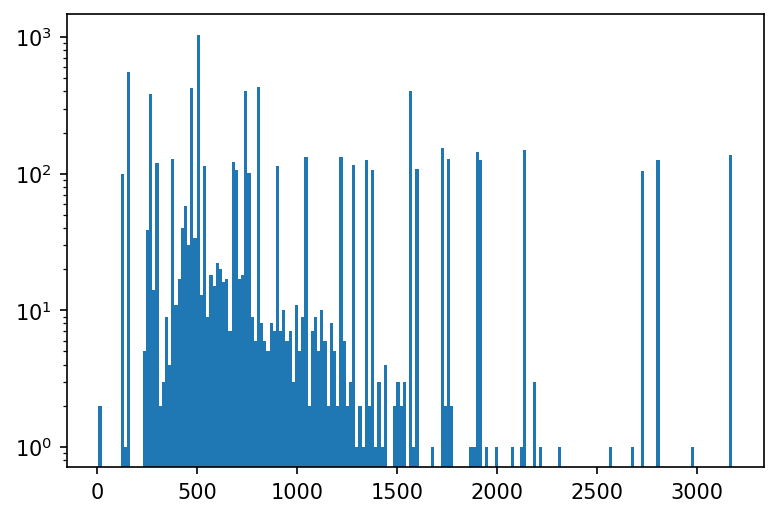

In [11]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(escape_energy), bins=200)
ax.semilogy();
#ax.set_xlim(0, 1)

In [12]:
ejecta_energy

0       368.700000
1       313.700000
2       368.700000
3       206.500000
4       206.500000
           ...    
5507      1.278677
5508     40.972111
5509     79.348605
5510     25.268222
5511     67.613988
Name: energy_input, Length: 5512, dtype: float64

In [13]:
ejecta_energy_df

,energy [eV/s/cm^-3]
0,33080.954597
1,22461.222013
2,14070.659221
3,7873.121280
4,5068.418425
5,2923.409137
6,2441.823428
7,1565.469662
8,1107.155111
9,755.517902


Scale deposited energy by total number of decays per second divided by number of decays simulated

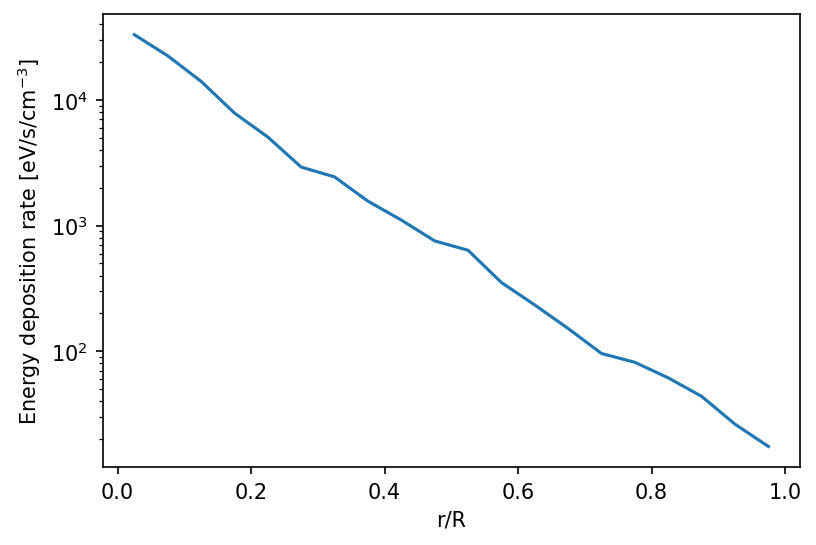

In [20]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.r_middle/np.max(model.r_outer), ejecta_energy_df)
plt.xlabel("r/R")
plt.ylabel("Energy deposition rate [eV/s/cm$^{-3}$]");